# Результаты однозадачного обучения IEMOCAP
### Использованные модели:
1. **AlexNet** <font color=green>[Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. <i>Commun. ACM</i> 60, 6 (June 2017), 84–90. DOI:https://doi.org/10.1145/3065386]</font> c немного измененной архитектурой, а именно:
    - Количество входных каналов первого сверточного слоя уменьшено с 3 до 1
    - Изменён последний свёрточный слой, его ядро увеличено с (3, 3) до (4, 4)
    - Изменён слой AdaptiveAvgPool2d с (6, 6) до (5, 5)
    - Изменён классификатор, теперь это четыре полносвязных слоя: 6400, 2048, 512, <число классов>
    - Добавлен Dropout() после первого и второго полносвязного слоя
2. **VGG-11, VGG-19** <font color=green>[Simonyan, Karen & Zisserman, Andrew. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv 1409.1556. ]</font>, также немного переделанные, чтобы соответствовать нашим данным
3. **ResNet-34, ResNet-50** <font color=green>[K. He, X. Zhang, S. Ren and J. Sun, "Deep Residual Learning for Image Recognition," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, 2016, pp. 770-778, doi: 10.1109/CVPR.2016.90.]</font>
4. **DeepNet** <font color=green>[Anvarjon, T.; Mustaqeem; Kwon, S. Deep-Net: A Lightweight CNN-Based Speech Emotion Recognition System Using Deep Frequency Features. Sensors 2020, 20, 5212.]</font><br>У этой архитектуры заявлена точность на четырехклассовом IEMOCAP 77%. Отличается использованием свёртки с ядрами от (11,1) до (1,1), таким образом, свёртка спектрограммы происходит только по частотной оси. На вход подаются спектрограммы размерности 64х64. <br>
5. **StrideNet** <font color=green>[., Mustaqeem & Kwon, Soonil. (2019). A CNN-Assisted Enhanced Audio Signal Processing for Speech Emotion Recognition. Sensors. 20. 183. 10.3390/s20010183. ]</font> <br> Ещё одна архитектура с высокой заявленной точностью.
Особенностью этой архитектуры является отсутствие Pooling слоёв: снижение размерности достигается использованием шага свёртки, равного двум. На вход подаются спектрограммы размером 128x128  <br>

### Датасет
Был использован IEMOCAP с четырьмя эмоциональными категориями (Anger, Happiness, Neutral, Sadness). Были протестированы следующие варианты: <br>
1. Без "аугментации", без препроцессинга
2. Без "аугментации", с препроцессингом
3. С "аугментацией", без препроцессинга
4. С "аугментацией", с препроцессингом

### Процесс обучения.
Все модели были обучены с использованием Adam, learning rate=1e-5, количество эпох - от 300 до 700. Также для ускорения процесса, поскольку вариантов много, в ходе экспериментов в процесс обучения была включена возможность остановить обучение, если validation loss не уменьшался на протяжении определенного количества эпох. Лучшие модели (с наименьшим показателем validation loss) сохранялись на жесткий диск с помощью pickle. 

In [1]:
import pandas as pd 
import pickle
import numpy as np 
import matplotlib.pyplot as plt
import os
from constants import *
from IPython.display import display 
import seaborn as sns 

In [4]:
def create_results_df(net):
    dfs_list = []
    for metric in ['acc', 'loss']:
        _dfs_list = []
        for subset in ['train', 'valid']:
            results = net.history[:, f'{subset}_{metric}']
            df = pd.DataFrame(results, columns=['result'])
            df['epochs'] = np.arange(1, len(results) + 1)
            df['subset'] = subset
            _dfs_list.append(df)
        df = pd.concat(_dfs_list, ignore_index=True)
        df['metric'] = metric
        dfs_list.append(df)
    final_df = pd.concat(dfs_list, ignore_index=True)
    return final_df

In [7]:
def create_results_summary():
    dfs_list = []
    models_list = [file for file in os.listdir(RESULTS_FOLDER) if file.endswith('md') and 'Ramas' in file]
    path_to_processed_list = os.path.join(RESULTS_FOLDER, 'processed_list.temp')
    if os.path.exists(path_to_processed_list):
        with open(path_to_processed_list, 'rb') as f:
            processed_list = pickle.load(f)
            files_list = processed_list['files']
            dfs_list = processed_list['dfs']
    else:
        processed_list = {}
        dfs_list = []
        files_list = []
    for file in models_list:
        print(file)
        if file in files_list:
            continue
        model, dataset = file[:-3].split('--')
        dataset, _, _, augmentation = dataset.split('_')
        augmentation = augmentation.split('-')[-1]
        with open(os.path.join(RESULTS_FOLDER, file), 'rb') as f:
            net = pickle.load(f)
        df = create_results_df(net)
        df['model'] = model
        df['dataset'] = dataset
        df['augmentation'] = augmentation
        print(df)
        dfs_list.append(df)
        files_list.append(file)
        processed_list['dfs'] = dfs_list
        processed_list['files'] = files_list
        with open(path_to_processed_list, 'wb') as f:
            pickle.dump(processed_list, f)
        print('///Done///')
    if len(files_list) == len(models_list):
        final_df = pd.concat(dfs_list, ignore_index=True)
        final_df.to_csv(os.path.join(RESULTS_FOLDER, 'ramas_all_results.csv'), sep = ';', index=False)

In [10]:
create_results_summary()

VGGNet--Ramas224Binary_224_train_augmentation-true.md
      result  epochs subset metric   model         dataset augmentation
0   0.829062       1  train    acc  VGGNet  Ramas224Binary         true
1   0.829575       2  train    acc  VGGNet  Ramas224Binary         true
2   0.830856       3  train    acc  VGGNet  Ramas224Binary         true
3   0.833419       4  train    acc  VGGNet  Ramas224Binary         true
4   0.838544       5  train    acc  VGGNet  Ramas224Binary         true
..       ...     ...    ...    ...     ...             ...          ...
63  0.380689      13  valid   loss  VGGNet  Ramas224Binary         true
64  0.445182      14  valid   loss  VGGNet  Ramas224Binary         true
65  0.444810      15  valid   loss  VGGNet  Ramas224Binary         true
66  0.652526      16  valid   loss  VGGNet  Ramas224Binary         true
67  0.379332      17  valid   loss  VGGNet  Ramas224Binary         true

[68 rows x 7 columns]
///Done///
VGGNet--Ramas224Descrete_224_train_augmentation-

### Результаты всех однозадачных моделей на датасете IEMOCAP содержатся в файле iemocap_all_results.csv

In [2]:
df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'iemocap_all_results.csv'), delimiter=';')
df

,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
0,0.398096,1,train,acc,VggNet,IEMOCAP-4,True,False
1,0.461926,2,train,acc,VggNet,IEMOCAP-4,True,False
2,0.521277,3,train,acc,VggNet,IEMOCAP-4,True,False
3,0.555151,4,train,acc,VggNet,IEMOCAP-4,True,False
4,0.561590,5,train,acc,VggNet,IEMOCAP-4,True,False
...,...,...,...,...,...,...,...,...
20299,0.933324,181,valid,loss,DeepNet,IEMOCAP-4,True,False
20300,0.926249,182,valid,loss,DeepNet,IEMOCAP-4,True,False
20301,0.929249,183,valid,loss,DeepNet,IEMOCAP-4,True,False
20302,0.919920,184,valid,loss,DeepNet,IEMOCAP-4,True,False


### Найдем результат лучшей модели (лучшей считается модель с наименьшим значением validation loss)

In [3]:
# Найдем лучший результат
val_losses = df.loc[(df['metric'] == 'loss') & (df['subset'] == 'valid')]
best_results = val_losses.groupby('model').min().sort_values('result')
best_results.drop(best_results.columns.tolist()[1:], axis=1, inplace=True)
best_results

,result
model,
VggNet,0.794945
AlexNet,0.808721
VggNet-19,0.843104
StrideNet,0.854611
ResNet50,0.874697
DeepNet,0.891184
ResNet34,1.017847


In [4]:
for result in best_results.result.tolist():
    _df = df.loc[df['result'] == result]
    display(_df)
    print(_df.model.values)

,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
6775,0.794945,210,valid,loss,VggNet,IEMOCAP-4,False,True


['VggNet']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
13265,0.808721,172,valid,loss,AlexNet,IEMOCAP-4,False,True


['AlexNet']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
4387,0.843104,19,valid,loss,VggNet-19,IEMOCAP-4,False,True


['VggNet-19']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
11591,0.854611,652,valid,loss,StrideNet,IEMOCAP-4,False,False


['StrideNet']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
979,0.874697,86,valid,loss,ResNet50,IEMOCAP-4,False,True


['ResNet50']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
12082,0.891184,40,valid,loss,DeepNet,IEMOCAP-4,False,False


['DeepNet']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
635,1.017847,2,valid,loss,ResNet34,IEMOCAP-4,False,True


['ResNet34']


### Итак, лучший результат показала VGG-11 с батч-нормализацией, без препроцессинга и с аугментацией <br> 
#### Построим графики обучения этой модели 

In [5]:
first_results = df.loc[(df['model'] == 'VggNet') & (df['preprocessing'] == False) & (df['augmentation'] == True) ]
first_results.loc[first_results['epochs'] == 210]

,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
6037,0.739362,210,train,acc,VggNet,IEMOCAP-4,False,True
6283,0.683091,210,valid,acc,VggNet,IEMOCAP-4,False,True
6529,0.671230,210,train,loss,VggNet,IEMOCAP-4,False,True
6775,0.794945,210,valid,loss,VggNet,IEMOCAP-4,False,True


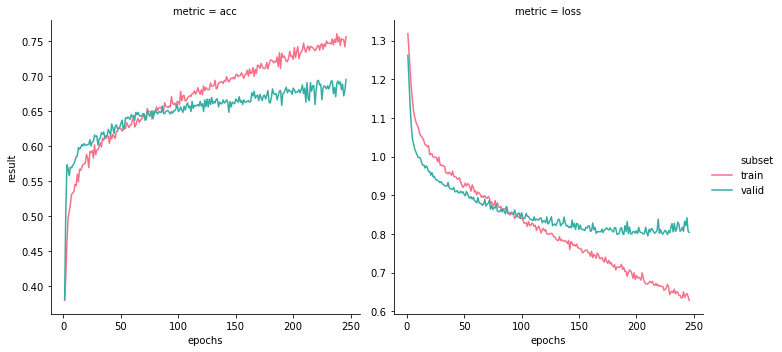

In [9]:
sns.relplot(x='epochs', y='result', hue='subset', size=None, style=None, 
            data=first_results, col='metric', palette='husl',
            kind='line', height=5, aspect=1, markers=True,
            facet_kws={
                'sharey': False
            })

### На втором месте с чуть меньшим validation loss - AlexNet, без препроцессинга и с аугментацией. 
#### Взглянем на эту модель тоже.

In [10]:
second_results = df.loc[(df['model'] == 'AlexNet') & (df['preprocessing'] == False) & (df['augmentation'] == True)]
second_results.loc[second_results['epochs'] == 172]

,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
12731,0.701568,172,train,acc,AlexNet,IEMOCAP-4,False,True
12909,0.683091,172,valid,acc,AlexNet,IEMOCAP-4,False,True
13087,0.741412,172,train,loss,AlexNet,IEMOCAP-4,False,True
13265,0.808721,172,valid,loss,AlexNet,IEMOCAP-4,False,True


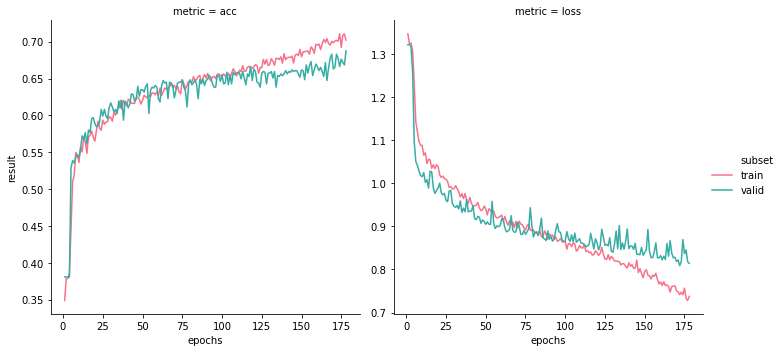

In [11]:
sns.relplot(x='epochs', y='result', hue='subset', size=None, style=None, 
            data=second_results, col='metric', palette='husl',
            kind='line', height=5, aspect=1, markers=True,
            facet_kws={
                'sharey': False
            })

Validation accuracy у этих моделей получился идентичный - 0.683

# Выводы.

Препроцессинг себя показал абсолютно никак, видно, что модели лучше справляются без него. Аугментация данных даже в том виде, в котором она есть, кажется эффективной, нужно расширять эту часть исследования.<br>
Наилучшие показатели в однозадачном обучении - у AlexNet и VggNet-11 c батч-нормализацией. Все дальнейшие улучшения будем проводить на основании этих двух моделей. <br>
Повторить результаты моделей DeepNet и StrideNet, описанные в соответствующих статьях - не удалось.

# Результаты RAMAS

In [7]:
df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'ramas_all_results.csv'), delimiter=';')
df

,result,epochs,subset,metric,model,dataset,augmentation
0,0.829062,1,train,acc,VGGNet,Ramas224Binary,True
1,0.829575,2,train,acc,VGGNet,Ramas224Binary,True
2,0.830856,3,train,acc,VGGNet,Ramas224Binary,True
3,0.833419,4,train,acc,VGGNet,Ramas224Binary,True
4,0.838544,5,train,acc,VGGNet,Ramas224Binary,True
...,...,...,...,...,...,...,...
407,0.384416,20,valid,loss,AlexNet,Ramas224Binary,True
408,0.414840,21,valid,loss,AlexNet,Ramas224Binary,True
409,0.381367,22,valid,loss,AlexNet,Ramas224Binary,True
410,0.375899,23,valid,loss,AlexNet,Ramas224Binary,True


In [8]:
descrete = df.loc[df['dataset'] == 'Ramas224Descrete']
binary = df.loc[df['dataset'] == 'Ramas224Binary']

In [9]:
val_losses = descrete.loc[(descrete['metric'] == 'loss') & (descrete['subset'] == 'valid')]
best_results = val_losses.groupby('model').min().sort_values('result')
best_results.drop(best_results.columns.tolist()[1:], axis=1, inplace=True)
best_results

,result
model,
VGGNet,1.451420
AlexNet,1.561813


In [10]:
for result in best_results.result.tolist():
    _df = df.loc[df['result'] == result]
    display(_df)
    print(_df.model.values)

,result,epochs,subset,metric,model,dataset,augmentation
167,1.45142,25,valid,loss,VGGNet,Ramas224Descrete,True


['VGGNet']


,result,epochs,subset,metric,model,dataset,augmentation
315,1.561813,37,valid,loss,AlexNet,Ramas224Descrete,True


['AlexNet']


In [12]:
first_results = df.loc[(df['model'] == 'AlexNet') & (df['augmentation'] == True) ]
first_results.loc[first_results['epochs'] == 37]

,result,epochs,subset,metric,model,dataset,augmentation
204,0.478729,37,train,acc,AlexNet,Ramas224Descrete,True
241,0.415984,37,valid,acc,AlexNet,Ramas224Descrete,True
278,1.372929,37,train,loss,AlexNet,Ramas224Descrete,True
315,1.561813,37,valid,loss,AlexNet,Ramas224Descrete,True


In [13]:
val_losses = binary.loc[(binary['metric'] == 'loss') & (binary['subset'] == 'valid')]
best_results = val_losses.groupby('model').min().sort_values('result')
best_results.drop(best_results.columns.tolist()[1:], axis=1, inplace=True)
best_results

,result
model,
VGGNet,0.371332
AlexNet,0.375461


In [14]:
for result in best_results.result.tolist():
    _df = df.loc[df['result'] == result]
    display(_df)
    print(_df.model.values)

,result,epochs,subset,metric,model,dataset,augmentation
67,0.371332,17,valid,loss,VGGNet,Ramas224Binary,True


['VGGNet']


,result,epochs,subset,metric,model,dataset,augmentation
411,0.375461,24,valid,loss,AlexNet,Ramas224Binary,True


['AlexNet']


In [16]:
first_results = df.loc[(df['model'] == 'VGGNet') & (df['augmentation'] == True) ]
first_results.loc[first_results['epochs'] == 17]

,result,epochs,subset,metric,model,dataset,augmentation
16,0.883393,17,train,acc,VGGNet,Ramas224Binary,True
33,0.865779,17,valid,acc,VGGNet,Ramas224Binary,True
50,0.297585,17,train,loss,VGGNet,Ramas224Binary,True
67,0.371332,17,valid,loss,VGGNet,Ramas224Binary,True
84,0.465915,17,train,acc,VGGNet,Ramas224Descrete,True
109,0.388320,17,valid,acc,VGGNet,Ramas224Descrete,True
134,1.442199,17,train,loss,VGGNet,Ramas224Descrete,True
159,1.618264,17,valid,loss,VGGNet,Ramas224Descrete,True
